<a href="https://colab.research.google.com/github/JavierAlbert/statArbCrypto/blob/master/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function
import collections
import os
import tensorflow as tf
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Embedding, Dropout, TimeDistributed
from keras.layers import LSTM
from keras.layers.recurrent import GRU
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import numpy as np
import pandas as pd
import io
import argparse
from google.colab import files
import matplotlib.pyplot as plt

# Load text files to Colab

In [2]:
uploadedFiles = files.upload()

Saving ptb.char.test.txt to ptb.char.test.txt
Saving ptb.char.train.txt to ptb.char.train.txt
Saving ptb.char.valid.txt to ptb.char.valid.txt
Saving ptb.test.txt to ptb.test.txt
Saving ptb.train.txt to ptb.train.txt
Saving ptb.valid.txt to ptb.valid.txt


# Define a load data function

In [0]:
def load_data(filename):
  
  # Read data
  with open(filename, 'rb') as f:
    text = f.read().decode("utf-8").replace("\n", "<eos>").split()

  # Count the number of times each word appears in the text
  counter = collections.Counter(text)
  
  # Sort in descending order and put it as pairs
  count_pairs = sorted(counter.items(), key=lambda x: (-x[1], x[0]))
  
  # keep the words only
  words, _ = list(zip(*count_pairs))
 
  # Make a dictionary where every word is assigned a number from 0 to len(words)
  # We call this the index of the word
  word_to_id = dict(zip(words, range(len(words))))
  
  # Build the initial text as numbers using the index of the word instead of the word
  textNum = [word_to_id[word] for word in text if word in word_to_id]
  
  # Calculate the number of different words. We call this 'vocabulary'
  vocabulary = len(word_to_id)
  
  # We reverse the dictionary. Indexes are the keys, words the values
  reversed_dictionary = dict(zip(word_to_id.values(), word_to_id.keys()))

  #print(textNum[:5])
  #print(word_to_id)
  #print(vocabulary)
  #print(" ".join([reversed_dictionary[x] for x in textNum[:10]]))
  
  return textNum, vocabulary, reversed_dictionary


train_data, vocabulary, reversed_dictionary = load_data('ptb.train.txt')
valid_data, _, _ = load_data('ptb.valid.txt')
test_data, _, _ = load_data('ptb.test.txt')

# Define the convergence plot function

In [0]:
def plotConvergence(history, title):
  # Get training and test loss histories
  training_loss = np.exp(history.history['loss'])
  test_loss = np.exp(history.history['val_loss'])

  # Create count of the number of epochs
  epoch_count = range(1, len(training_loss) + 1)

  # Visualize loss history
  plt.plot(epoch_count, training_loss, 'r--')
  plt.plot(epoch_count, test_loss, 'b-')
  plt.legend(['Train Perplexity', 'Test Perplexity'])
  plt.xlabel('Epoch')
  plt.ylabel('Perplexity')
  plt.title(title)
  #plt.ylim(0.7,1)

# Create a Batch generator object

In [0]:
class KerasBatchGenerator(object):

    def __init__(self, data, num_steps, batch_size, vocabulary, skip_step=5):
        self.data = data
        self.num_steps = num_steps
        self.batch_size = batch_size
        self.vocabulary = vocabulary
        self.current_idx = 0
        self.skip_step = skip_step

    def generate(self):
        x = np.zeros((self.batch_size, self.num_steps))
        y = np.zeros((self.batch_size, self.num_steps, self.vocabulary))
        while True:
            for i in range(self.batch_size):
                if self.current_idx + self.num_steps >= len(self.data):
                    self.current_idx = 0
                x[i, :] = self.data[self.current_idx:self.current_idx + self.num_steps]
                temp_y = self.data[self.current_idx + 1:self.current_idx + self.num_steps + 1]
                y[i, :, :] = to_categorical(temp_y, num_classes=self.vocabulary)
                self.current_idx += self.skip_step
            yield x, y

# Run LSTM with no dropout

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 20, 200)           2000000   
_________________________________________________________________
lstm_25 (LSTM)               (None, 20, 200)           320800    
_________________________________________________________________
lstm_26 (LSTM)               (None, 20, 200)           320800    
_________________________________________________________________
time_distributed_13 (TimeDis (None, 20, 10000)         2010000   
_________________________________________________________________
activation_13 (Activation)   (None, 20, 10000)         0         
Total params: 4,651,600
Trainable params: 4,651,600
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/13
1549/1549 [==============================] - 237s 153ms/step - loss: 6.8532 - categorical_accuracy: 0.0502 - val_los

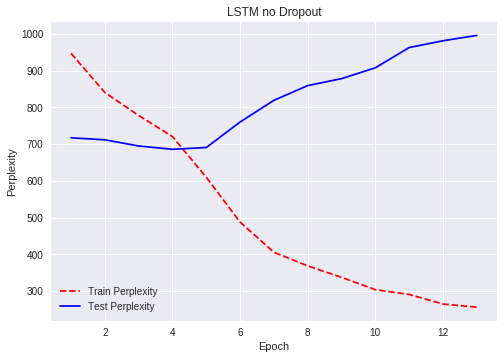

In [35]:
# Hyper parameters
num_epochs = 13
num_steps = 20
batch_size = 30
hidden_size = 200
learning_rate = 0.001

# Data generators
train_data_generator = KerasBatchGenerator(train_data, num_steps, batch_size, vocabulary,
                                           skip_step=num_steps)
valid_data_generator = KerasBatchGenerator(valid_data, num_steps, batch_size, vocabulary,
                                           skip_step=num_steps)

# Define Neural Network architecture
model = Sequential()
model.add(Embedding(vocabulary, hidden_size, input_length = num_steps))
model.add(LSTM(hidden_size, return_sequences=True))
model.add(LSTM(hidden_size, return_sequences=True))
model.add(TimeDistributed(Dense(vocabulary)))
model.add(Activation('softmax'))
model.compile(loss = 'categorical_crossentropy', 
              optimizer=keras.optimizers.Adam(lr=learning_rate), 
              metrics=['categorical_accuracy'])

print(model.summary())

historyLSTMnoDrop = model.fit_generator(train_data_generator.generate(), 
                                        steps_per_epoch = len(train_data)//(batch_size*num_steps), 
                                        epochs = num_epochs,
                                        validation_data = valid_data_generator.generate(),
                                        validation_steps = len(valid_data)//(batch_size*num_steps))

plotConvergence(historyLSTMnoDrop, 'LSTM no Dropout')

# Run LSTM with 50% dropout

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 20, 200)           2000000   
_________________________________________________________________
lstm_27 (LSTM)               (None, 20, 200)           320800    
_________________________________________________________________
lstm_28 (LSTM)               (None, 20, 200)           320800    
_________________________________________________________________
dropout_9 (Dropout)          (None, 20, 200)           0         
_________________________________________________________________
time_distributed_14 (TimeDis (None, 20, 10000)         2010000   
_________________________________________________________________
activation_14 (Activation)   (None, 20, 10000)         0         
Total params: 4,651,600
Trainable params: 4,651,600
Non-trainable params: 0
_________________________________________________________________


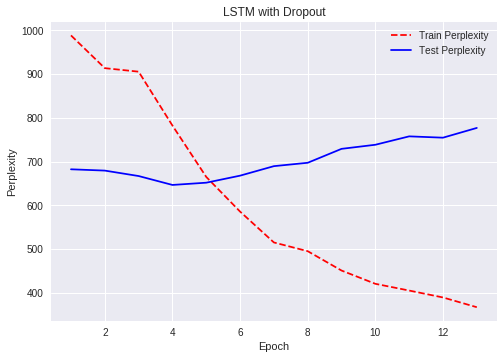

In [36]:
# Hyper parameters
num_epochs = 13
num_steps = 20
batch_size = 30
hidden_size = 200
learning_rate = 0.001
keep_prob = 0.5

# Data generators
train_data_generator = KerasBatchGenerator(train_data, num_steps, batch_size, vocabulary,
                                           skip_step=num_steps)
valid_data_generator = KerasBatchGenerator(valid_data, num_steps, batch_size, vocabulary,
                                           skip_step=num_steps)

# Define Neural Network architecture
model = Sequential()
model.add(Embedding(vocabulary, hidden_size, input_length = num_steps))
model.add(LSTM(hidden_size, return_sequences=True))
model.add(LSTM(hidden_size, return_sequences=True))
model.add(Dropout(1-keep_prob))
model.add(TimeDistributed(Dense(vocabulary)))
model.add(Activation('softmax'))
model.compile(loss = 'categorical_crossentropy', 
              optimizer=keras.optimizers.Adam(lr=learning_rate), 
              metrics=['categorical_accuracy'])

print(model.summary())

historyLSTMwithDrop = model.fit_generator(train_data_generator.generate(), 
                                        steps_per_epoch = len(train_data)//(batch_size*num_steps), 
                                        epochs = num_epochs,
                                        validation_data = valid_data_generator.generate(),
                                        validation_steps = len(valid_data)//(batch_size*num_steps))

plotConvergence(historyLSTMwithDrop, 'LSTM with Dropout')

# Run GRU with no dropout

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 20, 200)           2000000   
_________________________________________________________________
gru_1 (GRU)                  (None, 20, 200)           240600    
_________________________________________________________________
gru_2 (GRU)                  (None, 20, 200)           240600    
_________________________________________________________________
time_distributed_18 (TimeDis (None, 20, 10000)         2010000   
_________________________________________________________________
activation_18 (Activation)   (None, 20, 10000)         0         
Total params: 4,491,200
Trainable params: 4,491,200
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/13
1549/1549 [==============================] - 208s 134ms/step - loss: 6.7942 - categorical_accuracy: 0.0511 - val_los

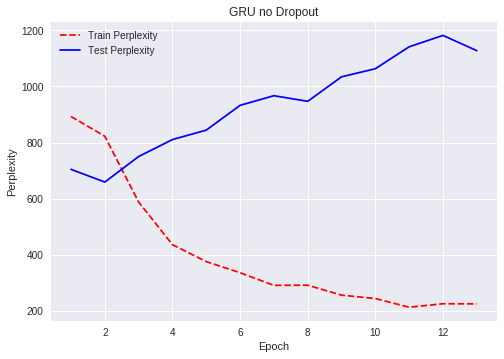

In [41]:
# Hyper parameters
num_epochs = 13
num_steps = 20
batch_size = 30
hidden_size = 200
learning_rate = 0.001

# Data generators
train_data_generator = KerasBatchGenerator(train_data, num_steps, batch_size, vocabulary,
                                           skip_step=num_steps)
valid_data_generator = KerasBatchGenerator(valid_data, num_steps, batch_size, vocabulary,
                                           skip_step=num_steps)

# Define Neural Network architecture
model = Sequential()
model.add(Embedding(vocabulary, hidden_size, input_length = num_steps))
model.add(GRU(hidden_size, return_sequences=True))
model.add(GRU(hidden_size, return_sequences=True))
model.add(TimeDistributed(Dense(vocabulary)))
model.add(Activation('softmax'))
model.compile(loss = 'categorical_crossentropy', 
              optimizer=keras.optimizers.Adam(lr=learning_rate), 
              metrics=['categorical_accuracy'])

print(model.summary())

historyGRUnoDrop = model.fit_generator(train_data_generator.generate(), 
                                        steps_per_epoch = len(train_data)//(batch_size*num_steps), 
                                        epochs = num_epochs,
                                        validation_data = valid_data_generator.generate(),
                                        validation_steps = len(valid_data)//(batch_size*num_steps))

plotConvergence(historyGRUnoDrop, 'GRU no Dropout')

# Run GRU with 50% dropout

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 20, 200)           2000000   
_________________________________________________________________
gru_3 (GRU)                  (None, 20, 200)           240600    
_________________________________________________________________
gru_4 (GRU)                  (None, 20, 200)           240600    
_________________________________________________________________
dropout_10 (Dropout)         (None, 20, 200)           0         
_________________________________________________________________
time_distributed_19 (TimeDis (None, 20, 10000)         2010000   
_________________________________________________________________
activation_19 (Activation)   (None, 20, 10000)         0         
Total params: 4,491,200
Trainable params: 4,491,200
Non-trainable params: 0
_________________________________________________________________


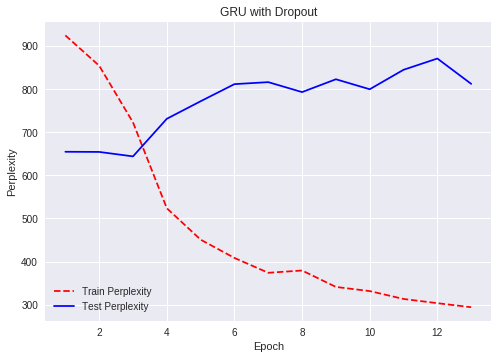

In [42]:
# Hyper parameters
num_epochs = 13
num_steps = 20
batch_size = 30
hidden_size = 200
learning_rate = 0.001
keep_prob = 0.5

# Data generators
train_data_generator = KerasBatchGenerator(train_data, num_steps, batch_size, vocabulary,
                                           skip_step=num_steps)
valid_data_generator = KerasBatchGenerator(valid_data, num_steps, batch_size, vocabulary,
                                           skip_step=num_steps)

# Define Neural Network architecture
model = Sequential()
model.add(Embedding(vocabulary, hidden_size, input_length = num_steps))
model.add(GRU(hidden_size, return_sequences=True))
model.add(GRU(hidden_size, return_sequences=True))
model.add(Dropout(1-keep_prob))
model.add(TimeDistributed(Dense(vocabulary)))
model.add(Activation('softmax'))
model.compile(loss = 'categorical_crossentropy', 
              optimizer=keras.optimizers.Adam(lr=learning_rate), 
              metrics=['categorical_accuracy'])

print(model.summary())

historyGRUwithDrop = model.fit_generator(train_data_generator.generate(), 
                                        steps_per_epoch = len(train_data)//(batch_size*num_steps), 
                                        epochs = num_epochs,
                                        validation_data = valid_data_generator.generate(),
                                        validation_steps = len(valid_data)//(batch_size*num_steps))

plotConvergence(historyGRUwithDrop, 'GRU with Dropout')